In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import scipy.optimize as spo
import cPickle as pickle
import portalocker
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import shutil, shelve
import tarfile
import time
import itertools as it
import matplotlib.lines as mlines
import matplotlib as mpl

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set(color_codes=True)
sns.set_context('talk', font_scale=1.75)
sns.set_palette("hls", 9)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})


def calcEqMat(edgei, edgej, node_pos, NN, NE, DIM):
    
    Q = np.zeros([DIM*NN, NE], float)

    for i in range(NE):
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        bvec /= la.norm(bvec)
        
        Q[DIM*edgei[i]:DIM*edgei[i]+DIM, i] = -bvec
        Q[DIM*edgej[i]:DIM*edgej[i]+DIM, i] = bvec
        
    return Q

Loading Mechanical Network Deformation Solver Module


In [5]:
net = NN2DTriLattice(8, 8, 1.0) 

rand.seed(666)

eta = 1
DIM = 2
NF = 1

NTS = 1

N_tune = 64
tune_list = [{} for i in range(N_tune)]


for n in range(N_tune):

    edgei = net.edgei
    edgej = net.edgej

    inodesi = [[] for t in range(NF)]
    inodesj = [[] for t in range(NF)]
    istrain_bonds = [[] for t in range(NF)]

    onodesi = [[] for t in range(NF)]
    onodesj = [[] for t in range(NF)]
    ostrain_bonds = [[] for t in range(NF)]

    edge = range(net.NE)

    rand.shuffle(edge)

    b = edge.pop()

    inodesi[0].append(edgei[b])
    inodesj[0].append(edgej[b])
    istrain_bonds[0].append(b)

    for i in range(NTS):
        b = edge.pop()

        onodesi[0].append(edgei[b])
        onodesj[0].append(edgej[b])
        ostrain_bonds[0].append(b)


#     print "inodes", inodesi, inodesj

#     print "onodes", onodesi, onodesj

#     print istrain_bonds
#     print ostrain_bonds

    isvec = [[] for t in range(NF)]
    for t in range(NF):
        for (i, j) in zip(inodesi[t], inodesj[t]):
            posi = net.node_pos[DIM*i:DIM*i+DIM]
            posj = net.node_pos[DIM*j:DIM*j+DIM]
            bvec = posj - posi
            bvec -= np.round(bvec/net.L)*net.L
            isvec[t].extend(bvec) 

    istrain = [[] for t in range(NF)]
    istrain[0].append(1.0)


    osvec = [[] for t in range(NF)]
    ostrain = [[] for t in range(NF)]
    for t in range(NF):
        for (i, j) in zip(onodesi[t], onodesj[t]):
            posi = net.node_pos[DIM*i:DIM*i+DIM]
            posj = net.node_pos[DIM*j:DIM*j+DIM]
            bvec = posj - posi
            bvec -= np.round(bvec/net.L)*net.L
            osvec[t].extend(bvec) 

            r = rand.randint(2)
            ostrain[t].append((2*r-1) * eta)

    pert = []
    meas = []
    for t in range(NF):
        pert.append(talgs.Perturb())
        pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

        meas.append(talgs.Measure())
        meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

    obj_func = mns.CyIneqRatioObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                            np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain))    

    
    tune_list[n]['pert'] = pert
    tune_list[n]['meas'] = meas
    tune_list[n]['obj_func'] = obj_func



NN 64
NB 192


In [6]:
K_disc = np.ones(net.NE, int)
K_max = np.ones(net.NE, float) / net.eq_length
Q = calcEqMat(net.edgei, net.edgej, net.node_pos, net.NN, net.NE, net.DIM)

obj_min = 0.0



for t in range(N_tune):

    tuner = talgs.TuneDiscLin(net, tune_list[t]['pert'], tune_list[t]['meas'], 
                              tune_list[t]['obj_func'], K_max, K_disc, NDISC=1)

    result = tuner.tune(verbose=False)

#             print b, t, result['niter'], result['result_msg'], result['success_flag']

    obj_min += result['niter']


print "Init", obj_min
    
for i in range(100):
    
    NSSS = int(np.sum(K_disc) - net.DIM*net.NN + DIM)
    
    K = K_disc * K_max
    
    M = np.sqrt(np.diag(K)).dot(Q.T.dot(Q.dot(np.sqrt(np.diag(K)))))
    (evals, evecs) = la.eigh(M)
    
    SSS = evecs[:, 0:NSSS]
    
    ntries = 0
    improve = False
    for b in rand.permutation(net.NE):
                       
        ntries += 1
        
        K_disc_tmp = np.copy(K_disc)
        
        if K_disc_tmp[b] == 1:
            Si = np.sum(SSS[b, :]**2)
            if Si < 1e-4:
                continue
                
            K_disc_tmp[b] = 0
        else:
            K_disc_tmp[b] = 1
                
        
        obj = 0.0
        
        for t in range(N_tune):
                        
            tuner = talgs.TuneDiscLin(net, tune_list[t]['pert'], tune_list[t]['meas'], 
                                      tune_list[t]['obj_func'], K_max, K_disc_tmp, NDISC=1)

            result = tuner.tune(verbose=False)
            
#             print b, t, result['niter'], result['result_msg'], result['success_flag']
            
            obj += result['niter']
            
                    
        if obj < obj_min:
            obj_min = obj
            
            K_disc[b] = K_disc_tmp[b]


            print i, "Attempts", ntries, "Obj", obj_min, "NE", np.sum(K_disc), "NSSS", NSSS

            print list(K_disc)
            
            improve = True
            
            
            break
            
        if obj < 0.1:
            print "Minimum Reached"
            break
            
    if not improve:
        print "No Improvement"
        break
            
    




Init 665.0
0 Attempts 1 Obj 635.0 NE 191 NSSS 66
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1 Attempts 1 Obj 618.0 NE 190 NSSS 65
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

KeyboardInterrupt: 

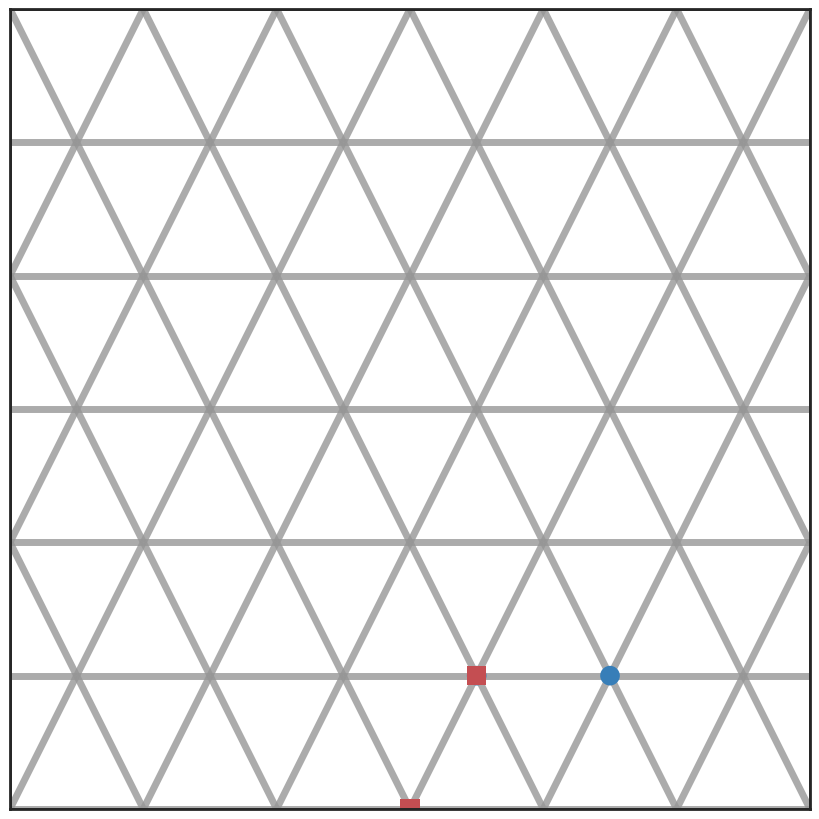

In [14]:
nplot.frame(net, np.zeros(DIM*net.NN, float), np.zeros([DIM, DIM], float), K_max, tune_list[7]['pert'][0], 
            tune_list[7]['meas'][0], "", 
            boxsize=0.5, padding=0.00, save=False, show_removed=True, ostrain=ostrain[0])

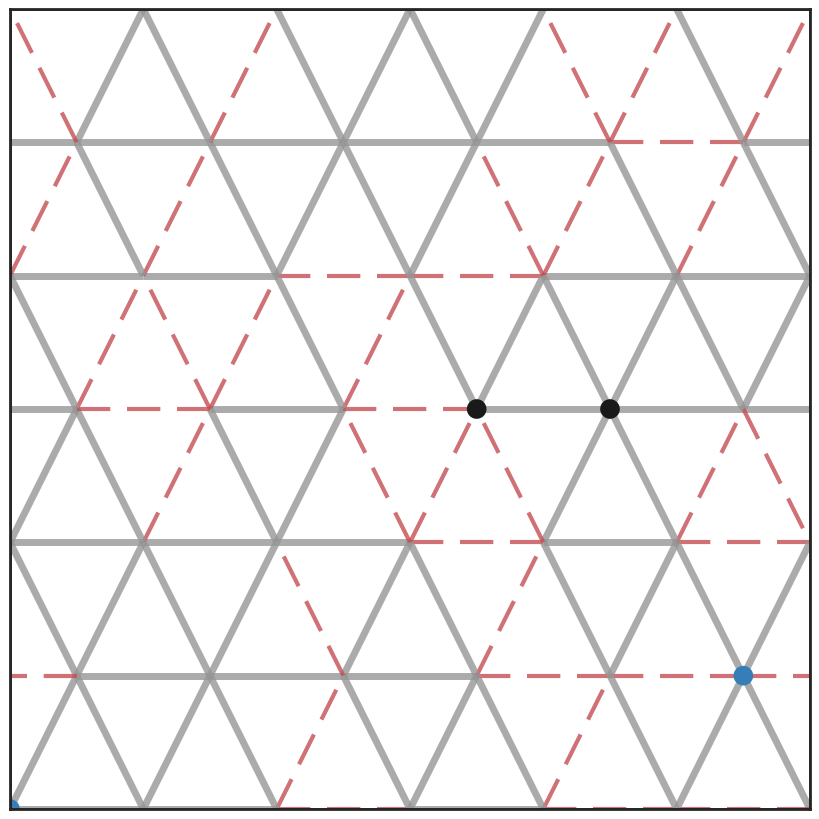

In [4]:
nplot.frame(net, np.zeros(DIM*net.NN, float), np.zeros([DIM, DIM], float), K_disc, tune_list[0]['pert'][0], 
            tune_list[0]['meas'][0], "", 
            boxsize=0.5, padding=0.00, save=False, show_removed=True, ostrain=ostrain[0])

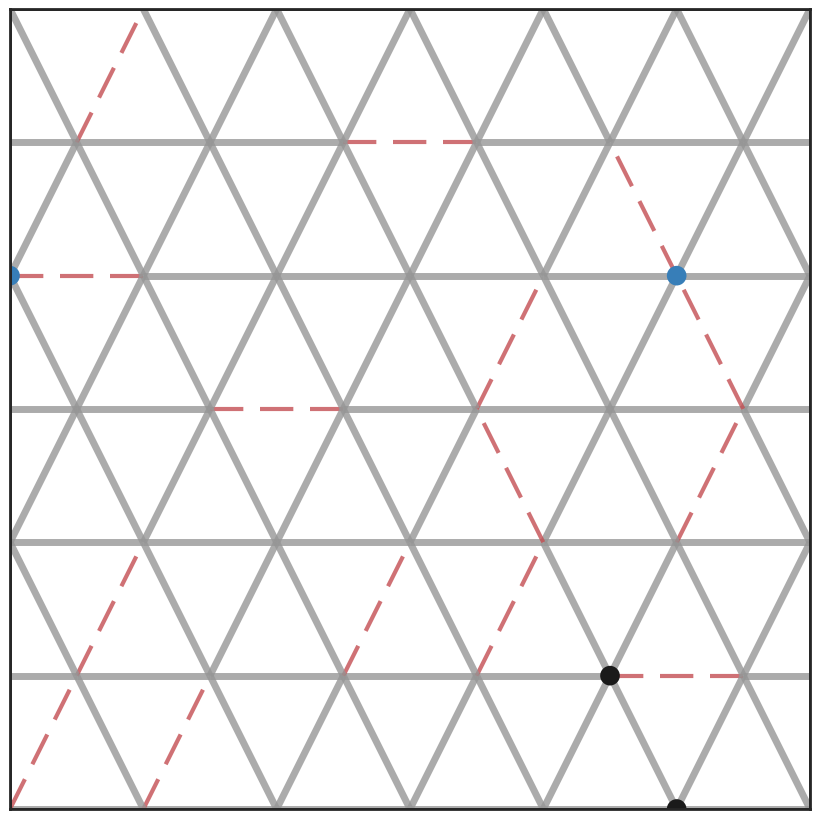

In [7]:
K = [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

K[79] = 0

nplot.frame(net, np.zeros(DIM*net.NN, float), np.zeros([DIM, DIM], float), K, tune_list[0]['pert'][0], 
            tune_list[0]['meas'][0], "", 
            boxsize=0.5, padding=0.00, save=False, show_removed=True, ostrain=ostrain[0])